In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing as mp
import numpy as np
import pandas as pd
import pickle
import h5py
from IPython.display import display, Math

from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import UnivariateSpline
from scipy.stats import lognorm, truncnorm, rv_continuous

import astropy.constants as const
import astropy.units as u
import astropy.uncertainty as unc
from astropy.cosmology import WMAP9, z_at_value
from astropy.modeling.functional_models import Linear1D, Const1D, Shift, Gaussian1D
from astropy.modeling.tabular import Tabular1D

from tqdm.autonotebook import tqdm

from src.models.agn_proxy import (Hopkins2007QuasarFormationDensity,
                                  LogNormal1D, Const3D, QuasarProxyBinaries,
                                  ModifiedSchechter)
from src.models.major_merger import (Schechter1D, Schechter2D,
                                     DoubleSchechter2D, TripleSchechter2D,
                                     PairFraction3D, PairFraction3D_3bins,
                                     Timescale3D, Sesana2013_Schechter,
                                     Sesana2013_DoubleSchechter,
                                     Sesana2013_TripleSchechter)

<ipython-input-1-a88728b5fd9d>:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Global variables
n_samples = int(2 ** 10)
n_mesh = int(2 ** 5)
n_samples, n_mesh

(1024, 32)

In [3]:
def trunc_norm_dist(a=0, b=np.inf, loc=0, scale=1, size=n_samples):
    return truncnorm.rvs(a=(a - loc) / scale, b=(b - loc) / scale,
                                          loc=loc, scale=scale,
                                          size=size)

# Parameter space

In [4]:
log_m_bh_min = 7
log_m_bh_max = 10

z_min = 0
z_max = 3

q_min = 0.25
q_max = 1

## Fiducial values

In [5]:
fidhz = (1 / u.yr).to(u.Hz)

# Load data

## AGN-proxy model

In [6]:
with h5py.File('../data/processed/agn_proxy.h5', 'r') as hf:
    log_m_bh_range = hf['log_m_bh_range'][:]
    z_range = hf['z_range'][:]
    q_range = hf['q_range'][:]
    hc_mm = hf['characteristic_strain'][:]

## S1

In [7]:
# the mass and the mass ratio ranges for all models are shared, so we will only load them once
with h5py.File('../data/processed/S1.h5', 'r') as hf:
    z_range_borch = hf['z_range'][:]
    S1_hc_mm = hf['characteristic_strain'][:]

## S2

In [8]:
with h5py.File('../data/processed/S2.h5', 'r') as hf:
    z_range_drory = hf['z_range'][:]
    S2_hc_mm = hf['characteristic_strain'][:]

## S3

In [9]:
with h5py.File('../data/processed/S3.h5', 'r') as hf:
    z_range_ilbert = hf['z_range'][:]
    S3_hc_mm = hf['characteristic_strain'][:]

# Load Models

#### Cappellari (2013)

In [10]:
with open('../models/Cappellari2013_mgal_mk_relation.pkl', 'rb') as f:
    cappellari_mgal_k = pickle.load(f)

print(cappellari_mgal_k)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
           slope              intercept      
    -------------------- --------------------
    -0.44113148091272636   0.4485862763648818
     -0.4589726543793738 0.043019388379139656
    -0.44076649794087536  0.44126064735036685
    -0.45181371999884967  0.19941646407111868
     -0.4392516658060743   0.4880474732867821
     -0.4437065453793867   0.3709427035409618
    -0.44147249040945935   0.4276824960662182
    -0.44479216524404863  0.33301001851208234
    -0.44682644728780396  0.30302285861957223
    -0.42311857123805574      0.8582392651732
                     ...                  ...
     -0.4511100559550033   0.2009781996327824
     -0.4518183644787433  0.20037013552496852
    -0.41768143906321575   0.9784879149163217
     -0.4452320081649608   0.3351597588639468
     -0.4305560843205788   0.6843954125311758
    -0.42444114457076176   0.8274616531299372
      -0.461504516309031 -0.02402377055127758


#### Kormendy & Ho (2013)

##### $M - M_{\rm{bulge}}$ model parameters

In [11]:
alpha_kormendy_ho = 9 + unc.normal(np.log10(.49), std=.05, n_samples=n_samples).distribution
beta_kormendy_ho = unc.normal(1.17, std=.08, n_samples=n_samples).distribution
intrinsic_disp_kormendy_ho = np.random.normal(scale=.28, size=n_samples)

##### $M - M_{\rm{bulge}}$ model

Scaled to $M_{\rm{bulge}} / 10^{11}\;\rm{M}_{\odot}$

In [12]:
mm_intercept = alpha_kormendy_ho - (beta_kormendy_ho * 11)
mm_slope = beta_kormendy_ho
kormendy_ho_m_mbulge = Linear1D(slope=mm_slope,
                                intercept=mm_intercept,
                                n_models=n_samples)

In [13]:
print(kormendy_ho_m_mbulge)
with open('../models/KormendyHo2013_mbh_mbulge_relation.pkl', 'wb') as f:
    pickle.dump(kormendy_ho_m_mbulge, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          slope             intercept     
    ------------------ -------------------
     1.228128185484955  -4.880076782692946
    1.1230334857388147 -3.5852247404016158
    1.0511285167902258  -2.797205187024373
     1.214793967242815  -4.587546715622992
    1.1800596876134395   -4.27562283364413
    1.2468289196481244  -5.044698249276756
     1.184436793483367  -4.292646688594203
    1.1695071461169357  -4.149383404311079
     1.201311375903676  -4.513657086836957
     1.167612385092848  -4.205371837280879
                   ...                 ...
    1.2995552567099666  -5.600274271944553
    1.1404026264488833 -3.8077541798787973
     1.196919785496936  -4.506201065051238
    1.1582873343919218 -4.0149584729851515
    1.1699329352376686  -4.160585339731327
    1.3082527764665508  -5.709550236127448
    1.1723342272479003  -4.215955603072672
     1.002434535393002  -2.301915452575347
     1.1779849449

### AGN-proxy model

#### $M_{\rm{BH}} - M_{\rm{K}}$

In [14]:
log_m_bh_m_k = cappellari_mgal_k | kormendy_ho_m_mbulge

#### Mingarelli+ (2017)

##### Mass ratio range

In [15]:
q_min_mingarelli = .25
q_max_mingarelli = 1

##### Mass ranges

In [16]:
galaxies = pd.read_csv('../data/external/25/added_mks.lst', delimiter='\s+',
                       usecols=[0, 1, 2, 3, 4], index_col=False)
galaxies = galaxies.append(pd.read_csv('../data/external/25/schutzMa_extension.txt',
                                       delimiter='\s+',
                                       usecols=[0, 1, 2, 3, 4],
                                       index_col=False))
catalog = pd.read_csv('../data/external/25/2mass_galaxies.lst', delimiter='\s+',
                      usecols=[1, 2, 3, 4, 5], index_col=False,
                      names=['RA', 'DEC', 'D_L(Mpc)', 'Kmag', 'Name'])
catalog

,RA,DEC,D_L(Mpc),Kmag,Name
0,189.998,-11.623,14.63,-25.88,NGC4594
1,187.445,8.000,20.78,-26.20,NGC4472
2,50.674,-37.208,19.76,-25.90,NGC1316
3,190.917,11.553,20.78,-25.86,NGC4649
4,187.706,12.391,20.78,-25.78,NGC4486
...,...,...,...,...,...
5105,214.458,0.511,223.09,-25.11,PGC051063
5106,64.351,-37.282,216.26,-25.05,PGC014806
5107,123.188,11.632,223.76,-25.13,PGC1396460
5108,206.159,21.093,218.77,-25.30,PGC3089894


In [17]:
log_m_bhb_mingarelli = np.array([log_m_bh_m_k(Mk) for Mk in catalog['Kmag']])
log_m_bhb_mingarelli = np.random.normal(log_m_bhb_mingarelli, .28)
log_m_bhb_mingarelli_q = np.quantile(log_m_bhb_mingarelli, q=[.16, .5, .84], axis=1)
log_m_bhb_mingarelli_max = np.max(log_m_bhb_mingarelli_q)
log_m_bhb_mingarelli_min = np.min(log_m_bhb_mingarelli_q)
display(Math(r'\log M_{{\rm{{BHB, min, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_min)))
display(Math(r'\log M_{{\rm{{BHB, max, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_max)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
log_m_bh_min_mingarelli = log_m_bhb_mingarelli_min - np.log10(1 + q_min_mingarelli)
log_m_bh_max_mingarelli = log_m_bhb_mingarelli_max - np.log10(1 + q_max_mingarelli)
log_m_bh_max = log_m_bh_max_mingarelli
display(Math(r'\log M_{{\rm{{BH, min, M17}}}} = {0:.2f}'
             .format(log_m_bh_min_mingarelli)))
display(Math(r'\log M_{{\rm{{BH, max, M17}}}} = {0:.2f}'
             .format(log_m_bh_max_mingarelli)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### $q$ Distribution

In [19]:
with open('../models/q_distrib.pkl', 'rb') as f:
    q_distrib = pickle.load(f)

print(q_distrib)

Model: LogNormal1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
     mu  std
    ---- ---
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
     ... ...
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    0.25 0.5
    Length = 1024 rows


#### Hopkins+ (2007)

In [20]:
with open('../models/Hopkins2007_quasar_formation_rate_binaries.pkl', 'rb') as f:
    quasar_formation_rate = pickle.load(f)

print(quasar_formation_rate)

Model: Hopkins2007QuasarFormationDensity
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1024
Parameters:
    log_formation_rate_normalization log_formation_rate_power_law_slope ... z_ref
    -------------------------------- ---------------------------------- ... -----
                 -3.8312291957759115                -3.5906422505854696 ...   2.0
                 -3.8135225285671623                 -3.821325480473623 ...   2.0
                 -3.7918640693698884                 -4.436947650694137 ...   2.0
                  -3.796869161261877                 -4.184330124395835 ...   2.0
                 -3.8354281273727096                -3.9616277353189626 ...   2.0
                 -3.8697805813436985                 -3.806463474235742 ...   2.0
                 -3.8695458373108753                 -4.174010429042026 ...   2.0
                 -3.8038888312393313                 -4.409515051910748 ...   2.0
                  -3.884021473405284                 -4.132194507176767

## Main models

### Mingarelli+ 2017 Derived $\Phi_{\rm{BHB}, 0}$

In [21]:
N_225 = np.rint(trunc_norm_dist(a=0, b=np.inf, loc=17, scale=6, size=n_samples))  # can't have fractions of a SMBHB
distance = 225 * u.Mpc

z_225 = z_at_value(WMAP9.angular_diameter_distance, distance, zmax=1.)
vol = WMAP9.comoving_volume(z_225).value

In [22]:
local_binary_number_density = Const1D(amplitude=N_225/vol, n_models=n_samples)

In [23]:
quantiles = np.quantile(local_binary_number_density(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [24]:
print(local_binary_number_density)
with open('../models/M17_number_density_kh.pkl', 'wb') as f:
    pickle.dump(local_binary_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1024
Parameters:
          amplitude       
    ----------------------
    1.7818748514659236e-07
     5.523812039544363e-07
     3.563749702931847e-07
    1.2473123960261466e-07
     3.385562217785255e-07
      3.74193718807844e-07
     3.920124673225032e-07
    1.0691249108795542e-07
    4.0983121583716244e-07
    2.6728122771988854e-07
                       ...
      3.74193718807844e-07
    1.7818748514659236e-07
     4.989249584104586e-07
     3.385562217785255e-07
     2.850999762345478e-07
     2.850999762345478e-07
    3.0291872474920704e-07
    2.3164373069057009e-07
    2.6728122771988854e-07
    1.6036873663193313e-07
      3.74193718807844e-07
    Length = 1024 rows


### AGN-proxy model

#### Normalization

In [25]:
# Add normalization masses to our mass range explicitly
log_m_bh_range_norm = np.sort(np.append(log_m_bh_range, log_m_bh_min_mingarelli))
log_m_bh_range_norm = np.sort(np.append(log_m_bh_range_norm, log_m_bh_max_mingarelli))
log_m_bh_range_norm = log_m_bh_range_norm[(log_m_bh_range_norm >= log_m_bh_min_mingarelli)
                                          & (log_m_bh_range_norm <= log_m_bh_max_mingarelli)]

In [26]:
mm, zz = np.meshgrid(log_m_bh_range_norm, z_range, indexing='ij')

In [27]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population = np.reshape(differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/480 [00:00<?, ?it/s]

In [28]:
local_quasar_number_density = trapz(differential_quasar_population, log_m_bh_range_norm, axis=0)[0]

quantiles = np.quantile(local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\Phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [29]:
q_factor = np.trapz(np.array([q_distrib(q) for q in q_range]), q_range, axis=0)

quantiles = np.quantile(q_factor, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\int_{{0.25}}^{{1}} p(q) dq = {0:.1f}'.format(quantiles[1])))

<IPython.core.display.Math object>

In [30]:
binary_agn_ratio = local_binary_number_density.amplitude / local_quasar_number_density

quantiles = np.quantile(binary_agn_ratio, q=[.16, .5, .84])
display(Math(r'\frac{{\Phi_{{\rm{{BHB}}, 0}}}}{{\Phi_{{\rm{{AGN}}, 0}}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [31]:
binary_normalization = Const3D(local_binary_number_density.amplitude / (local_quasar_number_density * q_factor), n_models=n_samples)

quantiles = np.quantile(binary_normalization.amplitude, q=[.16, .5, .84])
display(Math(r'N_{{0}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [32]:
print(binary_normalization)
with open('../models/BinaryNormalization_kh.pkl', 'wb') as f:
    pickle.dump(binary_normalization, f)

Model: Const3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
         amplitude     
    -------------------
     2.1080292659899436
      4.635676632418572
     2.0482701656361777
     1.6838830365819457
     3.1301874812406667
      5.297418143132724
     0.9666563215110355
    0.23406231181311718
      7.960253394813892
     1.6988152018451097
                    ...
     1.0930182496764012
     1.4017653240991756
     3.0222577138137887
      5.616205942629224
     1.3200338047076676
     1.7157711295938982
      4.724589536524818
     0.8635793559967065
     11.636915934565911
     0.8482939783590373
      6.767210139320451
    Length = 1024 rows


#### Full AGN-SMBHB model

In [33]:
with open('../models/SMBHBPopulation.pkl', 'rb') as f:
    differential_smbhb_population = pickle.load(f)
    differential_smbhb_population.log_local_smbhb_n_dens=np.log10(local_binary_number_density.amplitude)
    differential_smbhb_population.log_local_agn_n_dens=np.log10(local_quasar_number_density)

with open('../models/SMBHBPopulation_kh.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population, f)
    
print(differential_smbhb_population)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
    log_local_smbhb_n_dens log_local_agn_n_dens log_m_min ... mu_log_q std_log_q
    ---------------------- -------------------- --------- ... -------- ---------
        -6.749122801548517   -6.524066083956466       7.0 ...     0.25       0.5
        -6.257761107714245  -6.3749408877626665       7.0 ...     0.25       0.5
        -6.448092805884536   -6.210546691624524       7.0 ...     0.25       0.5
         -6.90402476153426  -6.5814033298881345       7.0 ...     0.25       0.5
        -6.470369200595688   -6.417006197273478       7.0 ...     0.25       0.5
        -6.426903506814598   -6.602034407905713       7.0 ...     0.25       0.5
       -6.4067001207263115   -5.843038862581118       7.0 ...     0.25       0.5
        -6.970971551164873   -5.791369687840399       7.0 ...     0.25       0.5
        -6.387394965530924  -6.7393885046403765       7.0 ...     0.25       0.5
     

<ipython-input-33-810cac86383c>:3: RuntimeWarning: divide by zero encountered in log10
  differential_smbhb_population.log_local_smbhb_n_dens=np.log10(local_binary_number_density.amplitude)


### Major merger models

#### S1: Borch+ (2006), Bundy+ (2009), Kitzbichler & White (2008)

In [34]:
with open('../models/S1.pkl', 'rb') as f:
    S1 = pickle.load(f)
    S1.alpha = alpha_kormendy_ho
    S1.beta = beta_kormendy_ho
    
with open('../models/S1_kh.pkl', 'wb') as f:
     pickle.dump(S1, f)

print(S1)

Model: Sesana2013_Schechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm1         ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
     8.62933325764156  1.228128185484955  0.003795060151100933 ...    2.2   20.0
    8.768143602725345 1.1230334857388147  0.004115014451254783 ...    2.2   20.0
     8.76520849766811 1.0511285167902258  0.004004440194266814 ...    2.2   20.0
    8.775186924047972  1.214793967242815   0.00411010842698342 ...    2.2   20.0
    8.705033730103704 1.1800596876134395 0.0033544663441562837 ...    2.2   20.0
    8.670419866852612 1.2468289196481244   0.00395001266926591 ...    2.2   20.0
    8.736158039722834  1.184436793483367  0.003246334998839639 ...    2.2   20.0
    8.715195202975215 1.1695071461169357 0.0038311136703111336 ...    2.2   20.0
    8.700768048103479  1.201311375903676  0.003589407476603303 ...    2.2   20.0
    

#### S2: Drory+ (2009), de Ravel+ (2009), Lotz+ (2010)

In [35]:
with open('../models/S2.pkl', 'rb') as f:
    S2 = pickle.load(f)
    S2.alpha = alpha_kormendy_ho
    S2.beta = beta_kormendy_ho

with open('../models/S2_kh.pkl', 'wb') as f:
     pickle.dump(S2, f)

print(S2)

Model: Sesana2013_DoubleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
     8.62933325764156  1.228128185484955 0.0043065703463104005 ...    1.1  100.0
    8.768143602725345 1.1230334857388147  0.004622253132452885 ...    1.1  100.0
     8.76520849766811 1.0511285167902258  0.004354766451569489 ...    1.1  100.0
    8.775186924047972  1.214793967242815  0.004370371433581013 ...    1.1  100.0
    8.705033730103704 1.1800596876134395  0.004601239515348178 ...    1.1  100.0
    8.670419866852612 1.2468289196481244  0.004317533695991045 ...    1.1  100.0
    8.736158039722834  1.184436793483367 0.0047829785761994625 ...    1.1  100.0
    8.715195202975215 1.1695071461169357  0.004220670991140153 ...    1.1  100.0
    8.700768048103479  1.201311375903676  0.004397916615570013 ...    1.1  100.

#### S3: Ilbert+ (2010), Lopez+ (2012), Kitzbichler & White (2008)

In [36]:
with open('../models/S3.pkl', 'rb') as f:
    S3 = pickle.load(f)
    S3.alpha = alpha_kormendy_ho
    S3.beta = beta_kormendy_ho

with open('../models/S3_kh.pkl', 'wb') as f:
     pickle.dump(S3, f)

print(S3)

Model: Sesana2013_TripleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 1024
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
     8.62933325764156  1.228128185484955 0.0043065703463104005 ...    2.2   30.0
    8.768143602725345 1.1230334857388147  0.004622253132452885 ...    2.2   30.0
     8.76520849766811 1.0511285167902258  0.004354766451569489 ...    2.2   30.0
    8.775186924047972  1.214793967242815  0.004370371433581013 ...    2.2   30.0
    8.705033730103704 1.1800596876134395  0.004601239515348178 ...    2.2   30.0
    8.670419866852612 1.2468289196481244  0.004317533695991045 ...    2.2   30.0
    8.736158039722834  1.184436793483367 0.0047829785761994625 ...    2.2   30.0
    8.715195202975215 1.1695071461169357  0.004220670991140153 ...    2.2   30.0
    8.700768048103479  1.201311375903676  0.004397916615570013 ...    2.2   30.

# Results

## AGN Models

### AGN-proxy

#### SMBHB Population

In [37]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [38]:
with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population = list(p.starmap(differential_smbhb_population,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population = np.reshape(differential_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Characteristic strain

In [39]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [40]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [41]:
hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
hc_q = np.quantile(hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(hc_q[1, -1, -1, -1] / order,
                     (hc_q[2, -1, -1, -1] - hc_q[1, -1, -1, -1]) / order,
                     (hc_q[1, -1, -1, -1] - hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [42]:
differential_number_density = trapz(trapz(differential_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
differential_number_density_q = np.quantile(differential_number_density, q=[.16, .5, .84], axis=-1)

In [43]:
order = 10. ** np.floor(np.log10(differential_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(differential_number_density_q[1, 0] / order,
                     (differential_number_density_q[2, 0] - differential_number_density_q[1, 0]) / order,
                     (differential_number_density_q[1, 0] - differential_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [44]:
local_bhmf = trapz(trapz(differential_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
local_bhmf_q = np.quantile(local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [45]:
with h5py.File('../data/processed/agn_proxy_kh.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range',  data=log_m_bh_range)
    hf.create_dataset('z_range',  data=z_range)
    hf.create_dataset('q_range',  data=q_range)
    hf.create_dataset('population',  data=differential_bhb_population)
    hf.create_dataset('characteristic_strain',  data=hc)
    hf.create_dataset('number_density',  data=differential_number_density)
    hf.create_dataset('local_bhmf',  data=local_bhmf)

## Merger Models

### S1

#### SMBHB Population

In [46]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_borch, q_range, indexing='ij')

In [47]:
with mp.Pool(mp.cpu_count()) as p:
    S1_bhb_population = list(p.starmap(S1,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S1_bhb_population = np.reshape(S1_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [48]:
S1_hc_integrand = (coeffs * S1_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [49]:
S1_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S1_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_borch, axis=1), q_range, axis=2))
S1_hc_q = np.quantile(S1_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S1_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S1_hc_q[1, -1, -1, -1] / order,
                     (S1_hc_q[2, -1, -1, -1] - S1_hc_q[1, -1, -1, -1]) / order,
                     (S1_hc_q[1, -1, -1, -1] - S1_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [50]:
S1_number_density = trapz(trapz(S1_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S1_number_density_q = np.quantile(S1_number_density, q=[.16, .5, .84], axis=-1)

In [51]:
order = 10. ** np.floor(np.log10(S1_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_number_density_q[1, 0] / order,
                     (S1_number_density_q[2, 0] - S1_number_density_q[1, 0]) / order,
                     (S1_number_density_q[1, 0] - S1_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [52]:
S1_local_bhmf = trapz(trapz(S1_bhb_population, q_range, axis=2), z_range_borch, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S1_local_bhmf_q = np.quantile(S1_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [53]:
with h5py.File('../data/processed/S1_kh.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range',  data=log_m_bh_range)
    hf.create_dataset('z_range',  data=z_range_borch)
    hf.create_dataset('q_range',  data=q_range)
    hf.create_dataset('population',  data=S1_bhb_population)
    hf.create_dataset('characteristic_strain',  data=S1_hc)
    hf.create_dataset('number_density',  data=S1_number_density)
    hf.create_dataset('local_bhmf',  data=S1_local_bhmf)

### S2

#### SMBHB Population

In [54]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_drory, q_range, indexing='ij')

In [55]:
with mp.Pool(mp.cpu_count()) as p:
    S2_bhb_population = list(p.starmap(S2,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S2_bhb_population = np.reshape(S2_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [56]:
S2_hc_integrand = (coeffs * S2_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [57]:
S2_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S2_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_drory, axis=1), q_range, axis=2))
S2_hc_q = np.quantile(S2_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S2_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S2_hc_q[1, -1, -1, -1] / order,
                     (S2_hc_q[2, -1, -1, -1] - S2_hc_q[1, -1, -1, -1]) / order,
                     (S2_hc_q[1, -1, -1, -1] - S2_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [58]:
S2_number_density = trapz(trapz(S2_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S2_number_density_q = np.quantile(S2_number_density, q=[.16, .5, .84], axis=-1)

In [59]:
order = 10. ** np.floor(np.log10(S2_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_number_density_q[1, 0] / order,
                     (S2_number_density_q[2, 0] - S2_number_density_q[1, 0]) / order,
                     (S2_number_density_q[1, 0] - S2_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [60]:
S2_local_bhmf = trapz(trapz(S2_bhb_population, q_range, axis=2), z_range_drory, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S2_local_bhmf_q = np.quantile(S2_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [61]:
with h5py.File('../data/processed/S2_kh.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_drory)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S2_bhb_population)
    hf.create_dataset('characteristic_strain', data=S2_hc)
    hf.create_dataset('number_density', data=S2_number_density)
    hf.create_dataset('local_bhmf', data=S2_local_bhmf)

### S3

#### SMBHB Population

In [62]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_ilbert, q_range, indexing='ij')

In [63]:
with mp.Pool(mp.cpu_count()) as p:
    S3_bhb_population = list(p.starmap(S3,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S3_bhb_population = np.reshape(S3_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [64]:
S3_hc_integrand = (coeffs * S3_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [65]:
S3_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S3_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_ilbert, axis=1), q_range, axis=2))
S3_hc_q = np.quantile(S3_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S3_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S3_hc_q[1, -1, -1, -1] / order,
                     (S3_hc_q[2, -1, -1, -1] - S3_hc_q[1, -1, -1, -1]) / order,
                     (S3_hc_q[1, -1, -1, -1] - S3_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [66]:
S3_number_density = trapz(trapz(S3_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S3_number_density_q = np.quantile(S3_number_density, q=[.16, .5, .84], axis=-1)

In [67]:
order = 10. ** np.floor(np.log10(S3_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_number_density_q[1, 0] / order,
                     (S3_number_density_q[2, 0] - S3_number_density_q[1, 0]) / order,
                     (S3_number_density_q[1, 0] - S3_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [68]:
S3_local_bhmf = trapz(trapz(S3_bhb_population, q_range, axis=2), z_range_ilbert, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S3_local_bhmf_q = np.quantile(S3_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [69]:
with h5py.File('../data/processed/S3_kh.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_ilbert)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S3_bhb_population)
    hf.create_dataset('characteristic_strain', data=S3_hc)
    hf.create_dataset('number_density',  data=S3_number_density)
    hf.create_dataset('local_bhmf', data=S3_local_bhmf)

## Plots

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [71]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

<ipython-input-72-c8a8d35b6c74>:134: RuntimeWarning: divide by zero encountered in log10
  ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
<ipython-input-72-c8a8d35b6c74>:137: RuntimeWarning: divide by zero encountered in log10
  ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',


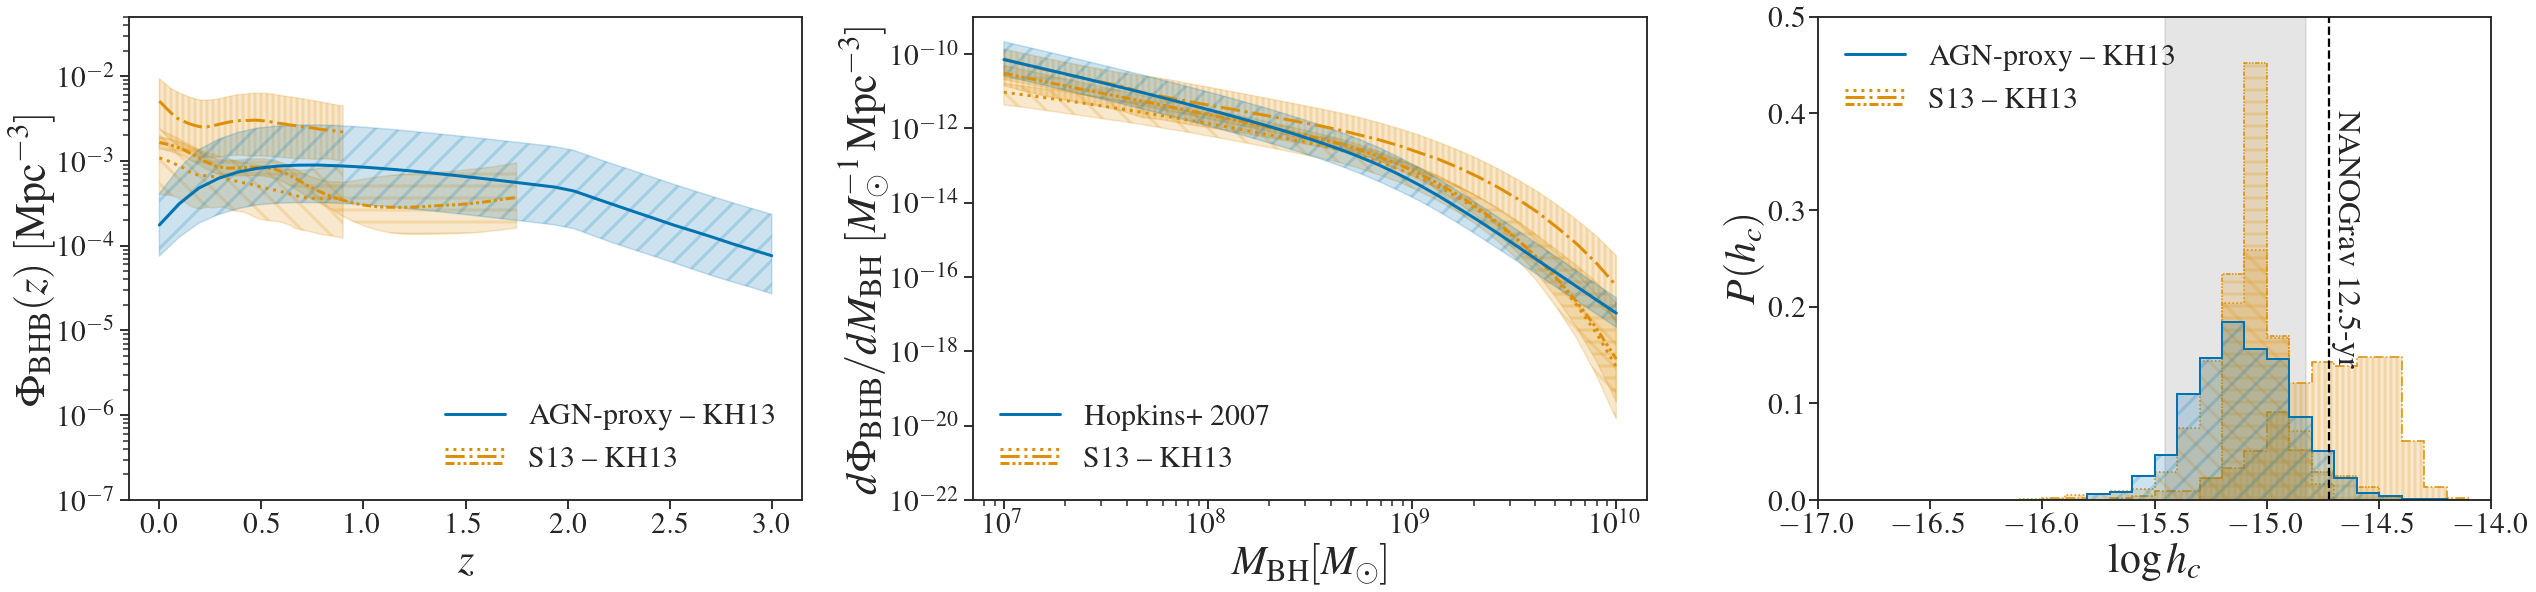

In [72]:
log_nz_i_l_kw_fid_min = np.floor(np.min(np.log10([np.min(differential_number_density_q[1]), np.min(S1_number_density_q[1]),
                                                  np.min(S2_number_density_q[1]), np.min(S3_number_density_q[1])])))
log_nz_i_l_kw_fid_max = np.ceil(np.max(np.log10([np.max(differential_number_density_q[1]), np.max(S1_number_density_q[1]),
                                                 np.max(S2_number_density_q[1]), np.max(S3_number_density_q[1])])))

hc_plot = hc[-1, -1, -1, :]
S1_hc_plot = S1_hc[-1, -1, -1, :]
S2_hc_plot = S2_hc[-1, -1, -1, :]
S3_hc_plot = S3_hc[-1, -1, -1, :]


log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((hc_plot[hc_plot != 0], S1_hc_plot[S1_hc_plot != 0],
                                                           S2_hc_plot[S1_hc_plot != 0], S3_hc_plot[S1_hc_plot != 0]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((hc_plot[hc_plot != 0], S1_hc_plot[S1_hc_plot != 0],
                                                          S2_hc_plot[S1_hc_plot != 0], S3_hc_plot[S1_hc_plot != 0]))))) / 10
bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(hc_q[1, -1, -1, -1])
log_hc_min = np.log10(hc_q[0, -1, -1, -1])
log_hc_max = np.log10(hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(1, 3, figsize=(36, 9))

label_fsize = 42
legend_fsize = 30

ax[0].tick_params()
ax[1].tick_params()

ax[0].fill_between(z_range_borch, S1_number_density_q[0], S1_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='\\')
s1, = ax[0].plot(z_range_borch, S1_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=':')
ax[0].fill_between(z_range_drory, S2_number_density_q[0], S2_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='||')
s2, = ax[0].plot(z_range_drory, S2_number_density_q[1], color=cs[1],
                linewidth=3, linestyle='-.')
ax[0].fill_between(z_range_ilbert, S3_number_density_q[0], S3_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='-')
s3, = ax[0].plot(z_range_ilbert, S3_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))

# ax[0].fill_between(z_range, nz_q[0], nz_q[2], color=cs[2], alpha=.2, hatch='.')
# m2, = ax[0].plot(z_range, nz_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[0].fill_between(z_range, differential_number_density_q[0], differential_number_density_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[0].plot(z_range, differential_number_density_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\Phi_{\rm{BHB}}(z)\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0].set_xlabel(r'$z$', fontsize=label_fsize)
# ax[0].set_ylim((10 ** (log_nz_i_l_kw_fid_min - 1), 10 ** (log_nz_i_l_kw_fid_max + 1)))
ax[0].set_ylim(top=5e-2, bottom=1e-7)

# ax[0].legend([m1, m2, (s1, s2, s3)], ['This Work', 'G19', 'S13 Realizations'], numpoints=1,
#              handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower right', fontsize=legend_fsize)
ax[0].legend([m1, (s1, s2, s3)], ['AGN-proxy -- KH13', 'S13 -- KH13'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='lower right', fontsize=legend_fsize)

ax[1].fill_between(10 ** log_m_bh_range, S1_local_bhmf_q[0], S1_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='\\')
s1, = ax[1].plot(10 ** log_m_bh_range, S1_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=':')
ax[1].fill_between(10 ** log_m_bh_range, S2_local_bhmf_q[0], S2_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='||')
s2, = ax[1].plot(10 ** log_m_bh_range, S2_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle='-.')
ax[1].fill_between(10 ** log_m_bh_range, S3_local_bhmf_q[0], S3_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='-')
s3, = ax[1].plot(10 ** log_m_bh_range, S3_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))

# ax[1].fill_between(10 ** log_m_bh_range, p_m_q[0], p_m_q[2], color=cs[2], alpha=.2, hatch='.')
# m2, = ax[1].plot(10 ** log_m_bh_range, p_m_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[1].fill_between(10 ** log_m_bh_range, local_bhmf_q[0], local_bhmf_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[1].plot(10 ** log_m_bh_range, local_bhmf_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[1].set_ylim(bottom=1e-22, top=1e-9)
# ax[1].legend([m1, m2, (s1, s2, s3)], ['Hopkins+ 2007', 'Marconi+ 2004', 'S13 Realizations'], numpoints=1,
#              handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower left', fontsize=legend_fsize)
ax[1].legend([m1, (s1, s2, s3)], ['Hopkins+ 2007', 'S13 -- KH13'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='lower left', fontsize=legend_fsize)

ax[2].axvspan(log_sesana_min, log_sesana_max, color='k', alpha=.1)
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='\\')
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='||')
ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='-')
ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])))

# ax[2].hist(np.log10(hc_g), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
#            label=r'G19', weights=np.repeat(1 / len(hc_g), len(hc_g)), linewidth=2, fill=True, alpha=.2, hatch='.')
# ax[2].hist(np.log10(hc_g), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
#            label=r'G19', weights=np.repeat(1 / len(hc_g), len(hc_g)), linewidth=2)

ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'AGN-proxy  - KH13', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'AGN-proxy  - KH13', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2)

# ax[2].annotate(r'S13',
#                xy=(log_sesana_min - .3, .49))
# ax[2].errorbar(log_hc_mid, 0.45,
#              xerr=[[log_hc_l],
#                    [log_hc_h]],
#              capsize=4, color=cs[0])
# ax[2].annotate(r'This Work',
#                xy=(log_hc_min - .75, .44))

ax[2].axvline(np.log10(1.9e-15), color='k', linestyle='--')
ax[2].annotate(r'NANOGrav 12.5-yr',
               xy=(np.log10(1.9e-15) + .03, .4), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=-90)
ax[2].set_xlabel(r'$\log h_{c}$', fontsize=label_fsize)
ax[2].set_ylabel(r'$P(h_{c})$', fontsize=label_fsize)
ax[2].set_xlim(left=-17, right=-14)
ax[2].set_ylim(top=.5)
# ax[2].legend([m1, m2, (s1, s2, s3)], ['This Work', 'G19', 'S13 Realizations'], numpoints=1,
#              handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)
ax[2].legend([m1, (s1, s2, s3)], ['AGN-proxy -- KH13', 'S13 -- KH13'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison_kh.pdf')
plt.savefig('../reports/figures/model_comparison_kh.png')
plt.show()

<ipython-input-73-469681a0d175>:56: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
<ipython-input-73-469681a0d175>:59: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',


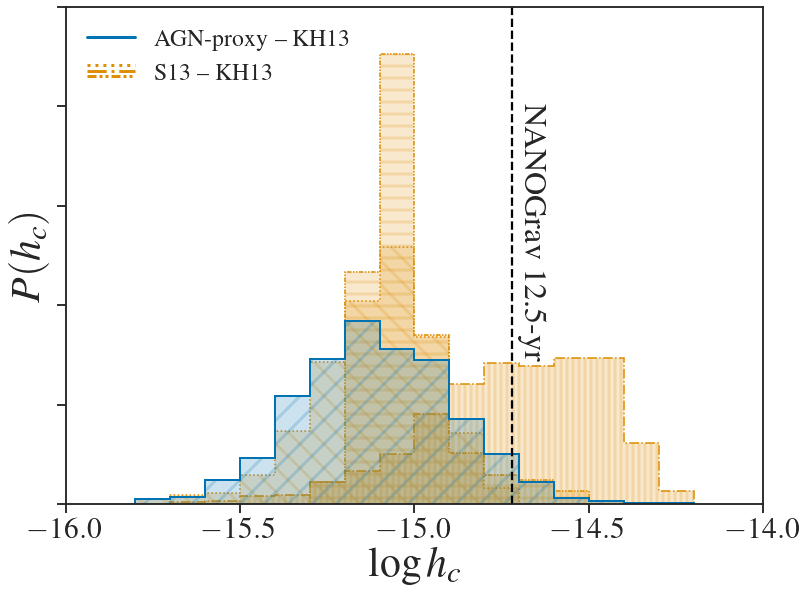

In [73]:
hc_mm_plot = hc_mm[-1, -1, -1, :]

log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((hc_plot[hc_plot != 0], hc_mm_plot[hc_mm_plot != 0]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((hc_plot[hc_plot != 0], hc_mm_plot[hc_mm_plot != 0]))))) / 10

bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(hc_q[1, -1, -1, -1])
log_hc_min = np.log10(hc_q[0, -1, -1, -1])
log_hc_max = np.log10(hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig = plt.figure(figsize=(12, 9))

label_fsize = 42
legend_fsize = 24

plt.hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='\\')
plt.hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])))

plt.hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='||')
plt.hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])))

plt.hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='-')
plt.hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])))

plt.hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
plt.hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'AGN-proxy  - KH13', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2)

plt.axvline(np.log10(1.9e-15), color='k', linestyle='--')
plt.annotate(r'NANOGrav 12.5-yr',
               xy=(np.log10(1.9e-15) + .03, .4), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=-90)
plt.xlabel(r'$\log h_{c}$', fontsize=label_fsize)
plt.ylabel(r'$P(h_{c})$', fontsize=label_fsize)
plt.xlim(left=-16, right=-14)
# plt.ylim(top=.5)
locs, _ = plt.yticks()
plt.yticks(locs, [])
plt.legend([m1, (s1, s2, s3)], ['AGN-proxy -- KH13', 'S13 -- KH13'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)

plt.tight_layout()
plt.savefig('../reports/figures/m_m_bulge_all.pdf')
plt.savefig('../reports/figures/m_m_bulge_all.png')
plt.show()

<ipython-input-74-35097ce141b3>:34: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
<ipython-input-74-35097ce141b3>:37: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',


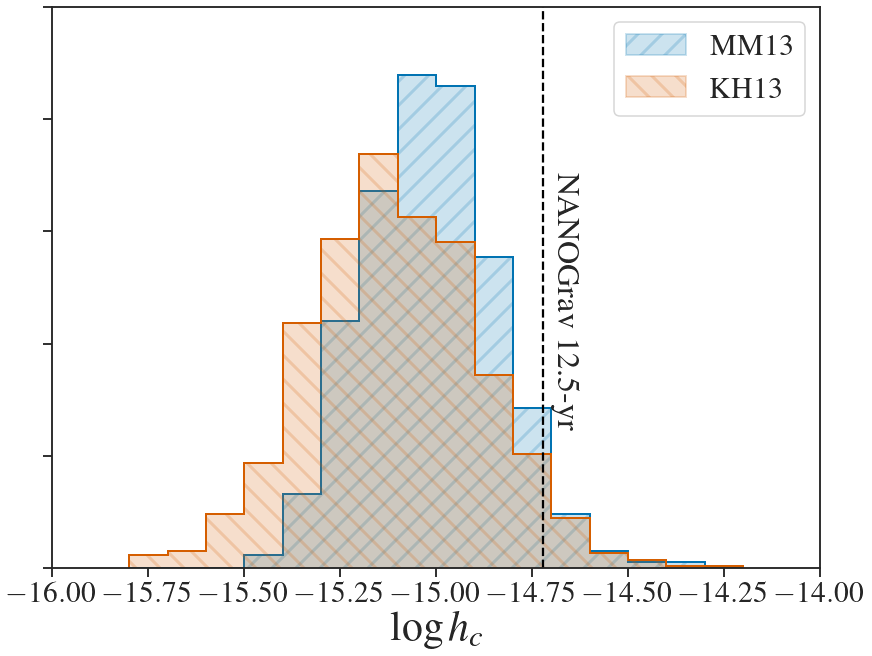

In [74]:
hc_mm_plot = hc_mm[-1, -1, -1, :]

log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((hc_plot[hc_plot != 0], hc_mm_plot[hc_mm_plot != 0]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((hc_plot[hc_plot != 0], hc_mm_plot[hc_mm_plot != 0]))))) / 10

bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(hc_q[1, -1, -1, -1])
log_hc_min = np.log10(hc_q[0, -1, -1, -1])
log_hc_max = np.log10(hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig = plt.figure(figsize=(12, 9), constrained_layout=True)

label_fsize = 42
legend_fsize = 30

plt.hist(np.log10(hc_mm[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'MM13', weights=np.repeat(1 / len(hc_mm[-1, -1, -1, :]), len(hc_mm[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
plt.hist(np.log10(hc_mm[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
         weights=np.repeat(1 / len(hc_mm[-1, -1, -1, :]), len(hc_mm[-1, -1, -1, :])), linewidth=2)
plt.hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
           label=r'KH13', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='\\')
plt.hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
         weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2)

plt.axvline(np.log10(1.9e-15), color='k', linestyle='--')
plt.annotate(r'NANOGrav 12.5-yr',
               xy=(np.log10(1.9e-15) + .03, .175), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=-90)
plt.xlabel(r'$\log h_{c}$', fontsize=label_fsize)
# plt.ylabel(r'$P(h_{c})$', fontsize=label_fsize)
plt.xlim(left=-16, right=-14)
# plt.ylim(top=.5)
locs, _ = plt.yticks()
plt.yticks(locs, [])
# locs, labels = plt.xticks()
# plt.xticks(locs[::2], labels[::2])
plt.legend(fontsize=legend_fsize)

# plt.tight_layout()
plt.savefig('../reports/figures/m_m_bulge_comparison.pdf')
plt.savefig('../reports/figures/m_m_bulge_comparison.png')
plt.show()

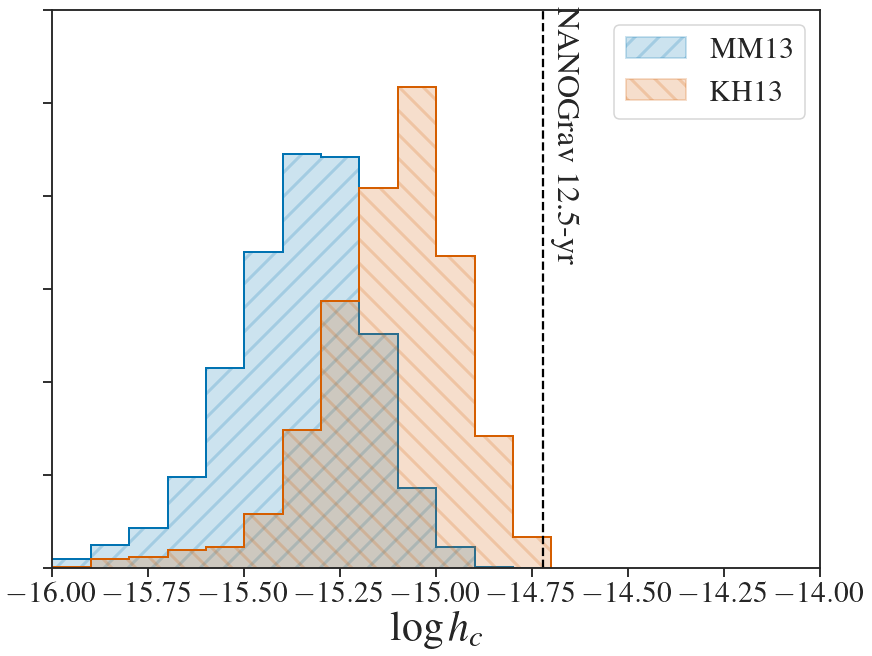

In [75]:
log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((S1_hc[-1, -1, -1, :], S1_hc_mm[-1, -1, -1, :]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((S1_hc[-1, -1, -1, :], S1_hc_mm[-1, -1, -1, :]))))) / 10

bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(S1_hc_q[1, -1, -1, -1])
log_hc_min = np.log10(S1_hc_q[0, -1, -1, -1])
log_hc_max = np.log10(S1_hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig = plt.figure(figsize=(12, 9), constrained_layout=True)

label_fsize = 42
legend_fsize = 30

plt.hist(np.log10(S1_hc_mm[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'MM13', weights=np.repeat(1 / len(S1_hc_mm[-1, -1, -1, :]), len(S1_hc_mm[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
plt.hist(np.log10(S1_hc_mm[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
         weights=np.repeat(1 / len(S1_hc_mm[-1, -1, -1, :]), len(S1_hc_mm[-1, -1, -1, :])), linewidth=2)
plt.hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
           label=r'KH13', weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='\\')
plt.hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
         weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])), linewidth=2)

plt.axvline(np.log10(1.9e-15), color='k', linestyle='--')
plt.annotate(r'NANOGrav 12.5-yr',
               xy=(np.log10(1.9e-15) + .03, .3), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=-90)
plt.xlabel(r'$\log h_{c}$', fontsize=label_fsize)
# plt.ylabel(r'$P(h_{c})$', fontsize=label_fsize)
plt.xlim(left=-16, right=-14)
# plt.ylim(top=.5)
locs, _ = plt.yticks()
plt.yticks(locs, [])
plt.legend(fontsize=legend_fsize)

# plt.tight_layout()
plt.savefig('../reports/figures/S1_m_m_bulge_comparison.pdf')
plt.savefig('../reports/figures/S1_m_m_bulge_comparison.png')
plt.show()

In [76]:
log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((S2_hc[-1, -1, -1, :], S2_hc_mm[-1, -1, -1, :]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((S2_hc[-1, -1, -1, :], S2_hc_mm[-1, -1, -1, :]))))) / 10

bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(S2_hc_q[1, -1, -1, -1])
log_hc_min = np.log10(S2_hc_q[0, -1, -1, -1])
log_hc_max = np.log10(S2_hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig = plt.figure(figsize=(12, 9), constrained_layout=True)

label_fsize = 42
legend_fsize = 30

plt.hist(np.log10(S2_hc_mm[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'MM13', weights=np.repeat(1 / len(S2_hc_mm[-1, -1, -1, :]), len(S2_hc_mm[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
plt.hist(np.log10(S2_hc_mm[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
         weights=np.repeat(1 / len(S2_hc_mm[-1, -1, -1, :]), len(S2_hc_mm[-1, -1, -1, :])), linewidth=2)
plt.hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
           label=r'KH13', weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='\\')
plt.hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
         weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])), linewidth=2)

plt.axvline(np.log10(1.9e-15), color='k', linestyle='--')
plt.annotate(r'NANOGrav 12.5-yr',
               xy=(np.log10(1.9e-15) + .03, .3), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=-90)
plt.xlabel(r'$\log h_{c}$', fontsize=label_fsize)
# plt.ylabel(r'$P(h_{c})$', fontsize=label_fsize)
plt.xlim(left=-16, right=-14)
# plt.ylim(top=.5)
locs, _ = plt.yticks()
plt.yticks(locs, [])
plt.legend(fontsize=legend_fsize)
plt.

# plt.tight_layout()
plt.savefig('../reports/figures/S2_m_m_bulge_comparison.pdf')
plt.savefig('../reports/figures/S2_m_m_bulge_comparison.png')
plt.show()

SyntaxError: invalid syntax (<ipython-input-76-d1d3a29e3f64>, line 49)

In [ ]:
log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((S3_hc[-1, -1, -1, :], S3_hc_mm[-1, -1, -1, :]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((S3_hc[-1, -1, -1, :], S3_hc_mm[-1, -1, -1, :]))))) / 10

bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(S3_hc_q[1, -1, -1, -1])
log_hc_min = np.log10(S3_hc_q[0, -1, -1, -1])
log_hc_max = np.log10(S3_hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig = plt.figure(figsize=(12, 9), constrained_layout=True)

label_fsize = 42
legend_fsize = 30

plt.hist(np.log10(S3_hc_mm[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'MM13', weights=np.repeat(1 / len(S3_hc_mm[-1, -1, -1, :]), len(S3_hc_mm[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
plt.hist(np.log10(S3_hc_mm[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
         weights=np.repeat(1 / len(S3_hc_mm[-1, -1, -1, :]), len(S3_hc_mm[-1, -1, -1, :])), linewidth=2)
plt.hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
           label=r'KH13', weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='\\')
plt.hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[3], linestyle='-',
         weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])), linewidth=2)

plt.axvline(np.log10(1.9e-15), color='k', linestyle='--')
plt.annotate(r'NANOGrav 12.5-yr',
               xy=(np.log10(1.9e-15) + .03, .3), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=-90)
plt.xlabel(r'$\log h_{c}$', fontsize=label_fsize)
# plt.ylabel(r'$P(h_{c})$', fontsize=label_fsize)
plt.xlim(left=-16, right=-14)
# plt.ylim(top=.5)
locs, _ = plt.yticks()
plt.yticks(locs, [])
plt.legend(fontsize=legend_fsize)

# plt.tight_layout()
plt.savefig('../reports/figures/S3_m_m_bulge_comparison.pdf')
plt.savefig('../reports/figures/S3_m_m_bulge_comparison.png')
plt.show()